<a href="https://colab.research.google.com/github/AshkanDee/OD-flow-Clustering/blob/main/Codex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This cell is for mounting Google Drive in a Python runtime.
# If your notebook is in an R runtime, you would typically use system commands
# or switch back to Python to mount the drive.
# Since we are currently in an R runtime, I'm providing a Python cell to mount the drive.
# You will need to execute this in a Python runtime and then switch back to R.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Prevent scientific notation globally
options(scipen = 999)

# Install vctrs first (do not load any other packages yet)
if (!requireNamespace("vctrs", quietly = TRUE)) {
  install.packages("vctrs")
}

# Install required packages for setup + city inspection
required_packages <- c("data.table", "dbscan", "ggplot2", "dplyr")
missing_packages <- required_packages[!vapply(required_packages, requireNamespace, logical(1), quietly = TRUE)]
if (length(missing_packages) > 0) {
  install.packages(missing_packages)
}

# Load packages AFTER installation
suppressPackageStartupMessages({
  library(vctrs)
  library(data.table)
  library(dbscan)
  library(ggplot2)
  library(dplyr)
})


In [2]:
############################################################
# Step 1 — Load + inspect all cities (no combining)
#
# WHY:
# - Quick schema check across cities in one run
# - Confirms consistency before you start clustering
# - Does NOT merge/stack datasets (each city stays separate)
############################################################

city_paths <- list(
  berlin  = "/content/drive/MyDrive/berlin_flows_utm.rds",
  munich  = "/content/drive/MyDrive/munich_flows_utm.rds",
  cologne = "/content/drive/MyDrive/cologne_flows_utm.rds"
)

# Store each city separately (no combining)
city_data <- lapply(names(city_paths), function(city_id) {
  dt <- readRDS(city_paths[[city_id]])
  dt <- as.data.table(dt)
  dt[, city := city_id]  # traceability tag
  dt
})
names(city_data) <- names(city_paths)

# Print inspection for each city
for (city_id in names(city_data)) {
  dt <- city_data[[city_id]]

  cat("\n=============================\n")
  cat("CITY:", toupper(city_id), "\n")
  cat("=============================\n")

  cat("class():\n")
  print(class(dt))

  cat("\ndim():\n")
  print(dim(dt))

  cat("\nnames():\n")
  print(names(dt))
}


CITY: BERLIN 
class():
[1] "data.table" "data.frame"

dim():
[1] 173854     29

names():
 [1] "id"               "ride"             "start_loc_lon"    "start_loc_lat"   
 [5] "dest_loc_lon"     "dest_loc_lat"     "start_time"       "dest_time"       
 [9] "distance"         "duration"         "provider"         "city"            
[13] "charge_start"     "charge_dest"      "weekday"          "start_hour"      
[17] "day"              "part_of_week"     "network_distance" "charge_loss_pp"  
[21] "id_new"           "x_o"              "y_o"              "x_d"             
[25] "y_d"              "dx"               "dy"               "angle"           
[29] "len"             

CITY: MUNICH 
class():
[1] "data.table" "data.frame"

dim():
[1] 181371     21

names():
 [1] "id"            "ride"          "start_loc_lat" "start_loc_lon"
 [5] "dest_loc_lat"  "dest_loc_lon"  "start_time"    "dest_time"    
 [9] "distance"      "duration"      "scooter_id"    "provider"     
[13] "city"          "

In [3]:
############################################################
# Step 2 — Structural correction + scaling (per city)
#
# WHAT this step produces:
# - X_scaled: scaled feature matrix for clustering
# - city_clean: filtered dataset aligned with X_scaled rows
#
# Key decisions (explicit WHY):
# - We drop rows with NA in clustering features (complete.cases)
#   because distance-based clustering cannot handle missing values reliably.
# - We scale features because DBSCAN/HDBSCAN use distance computations;
#   scaling prevents any one dimension from dominating due to units/magnitude.
############################################################

make_X_and_clean <- function(city_dt,
                             feature_cols = c("x_o", "y_o", "dx", "dy")) {

  # WHY: fail fast if a city has a different schema (examiner-friendly)
  missing_cols <- setdiff(feature_cols, names(city_dt))
  if (length(missing_cols) > 0) {
    stop("Missing required columns: ", paste(missing_cols, collapse = ", "))
  }

  # Build feature matrix (same as your berlin snippet, just generalized)
  X <- city_dt %>%
    dplyr::select(dplyr::all_of(feature_cols)) %>%
    as.matrix()

  # Drop rows with any NA in features
  ok <- complete.cases(X)

  # Scale only the valid rows
  X_scaled <- scale(X[ok, , drop = FALSE])

  # Keep dataset aligned with X_scaled rows
  city_clean <- city_dt[ok, ]

  list(X = X[ok, , drop = FALSE], ok = ok, X_scaled = X_scaled, city_clean = city_clean)
}

# ---- Run for all cities (no combining)
# Assumes you already created: city_data$berlin, city_data$munich, city_data$cologne
prepared <- lapply(names(city_data), function(city_id) {
  res <- make_X_and_clean(city_data[[city_id]])
  res$city_id <- city_id
  res
})
names(prepared) <- names(city_data)

############################################################
# Step 2b — Store total trips per city (used by eval_solution)
############################################################

N_total_by_city <- sapply(names(prepared), function(city_id) {
  nrow(prepared[[city_id]]$X)   # filtered X, aligned with X_scaled
})

print(N_total_by_city)

# ---- Optional: keep Berlin-style objects for your existing code compatibility
berlin_clean  <- prepared$berlin$city_clean
munich_clean  <- prepared$munich$city_clean
cologne_clean <- prepared$cologne$city_clean

X_scaled_berlin  <- prepared$berlin$X_scaled
X_scaled_munich  <- prepared$munich$X_scaled
X_scaled_cologne <- prepared$cologne$X_scaled

# Quick audit print (helps you catch NA issues early)
for (city_id in names(prepared)) {
  cat("\n---", toupper(city_id), "---\n")
  cat("Rows original:", nrow(city_data[[city_id]]), "\n")
  cat("Rows kept:",     nrow(prepared[[city_id]]$city_clean), "\n")
  cat("Rows dropped:",  sum(!prepared[[city_id]]$ok), "\n")
  cat("X_scaled dim:",  paste(dim(prepared[[city_id]]$X_scaled), collapse = " x "), "\n")
}

 berlin  munich cologne 
 173854  181371   72770 

--- BERLIN ---
Rows original: 173854 
Rows kept: 173854 
Rows dropped: 0 
X_scaled dim: 173854 x 4 

--- MUNICH ---
Rows original: 181371 
Rows kept: 181371 
Rows dropped: 0 
X_scaled dim: 181371 x 4 

--- COLOGNE ---
Rows original: 72770 
Rows kept: 72770 
Rows dropped: 0 
X_scaled dim: 72770 x 4 



Plotting kNN-distance curves for: BERLIN 

Plotting kNN-distance curves for: MUNICH 


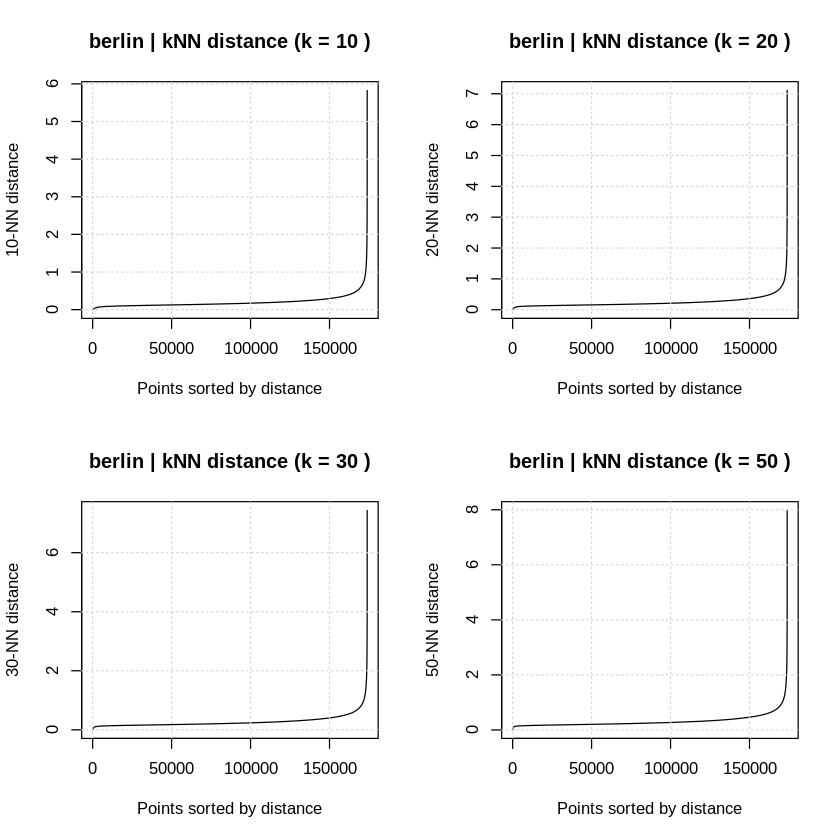


Plotting kNN-distance curves for: COLOGNE 


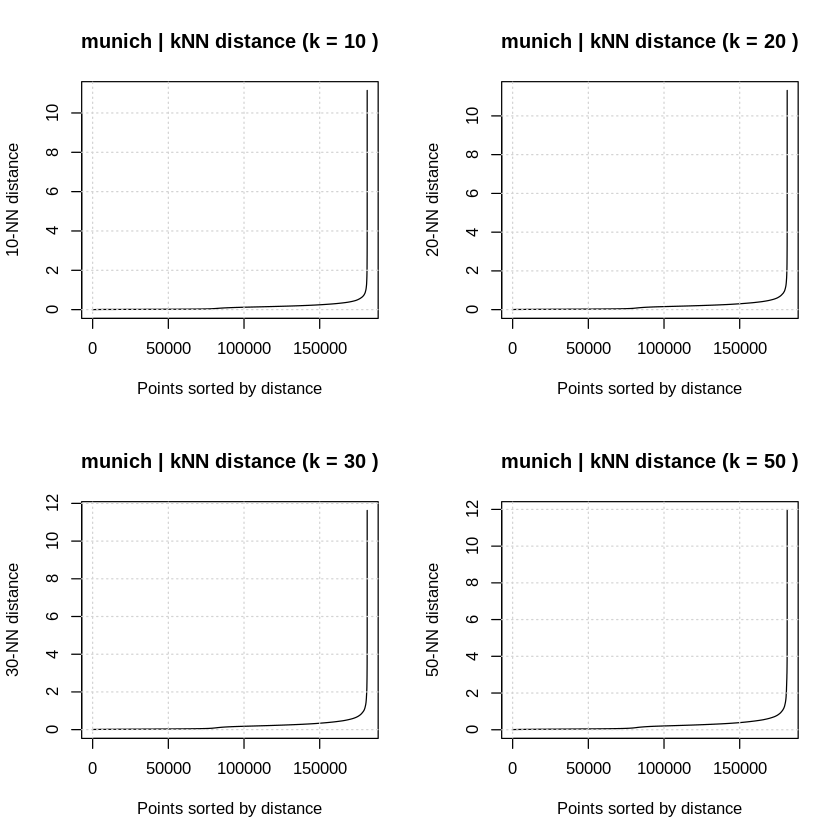

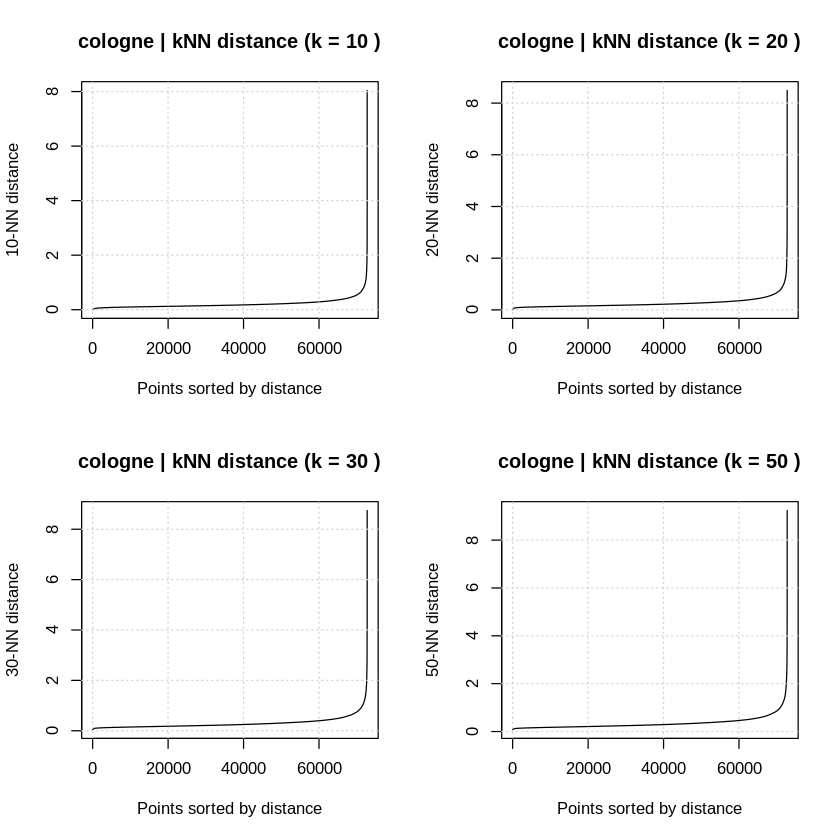

In [9]:
############################################################
# Step 3 — kNN-distance plot configuration
#
# WHY this step:
# - kNN-distance plots are used to visually assess a reasonable
#   neighborhood scale (eps) for density-based clustering.
# - We inspect multiple k values to understand sensitivity
#   across different minimum neighborhood sizes.
#
# IMPORTANT:
# - These k values are diagnostic only (not optimization yet).
# - They are aligned with minPts values later used in DBSCAN/HDBSCAN
#   for consistency and interpretability.
############################################################

# Chosen k values (same across all cities)
# WHY these values:
# - 10   : captures local dense patterns
# - 20-30: moderate neighborhood size (often stable)
# - 50   : stress-test for over-smoothing
k_values <- c(10, 20, 30, 50)

############################################################
# Step 3a — Plot layout setup (kNN-distance diagnostics)
#
# WHY this step:
# - We visualize multiple kNN-distance plots side-by-side
#   to compare neighborhood scales for different k values.
# - A fixed 2x2 layout is sufficient for the chosen k grid (4 values).
#
# SAFETY:
# - We store the original graphical parameters and restore them later
#   to avoid side effects on subsequent plots.
############################################################

# Save current graphical parameters
old_par <- par(no.readonly = TRUE)

# Set plotting layout (one panel per k value)
par(mfrow = c(2, 2))

############################################################
# Step 3b — kNN-distance plots
# WHY: visual support for choosing a reasonable eps scale
############################################################

for (city_id in names(prepared)) {

  X_scaled <- prepared[[city_id]]$X_scaled

  cat("\nPlotting kNN-distance curves for:", toupper(city_id), "\n")

  old_par_city <- par(no.readonly = TRUE)
  par(mfrow = c(2, 2))

  for (k in k_values) {
    kNN <- kNNdist(X_scaled, k = k)

    plot(sort(kNN), type = "l",
         xlab = "Points sorted by distance",
         ylab = paste0(k, "-NN distance"),
         main = paste(city_id, "| kNN distance (k =", k, ")"))

    grid()
  }

  par(old_par_city)
}


In [10]:
# Restore original graphics settings
par(old_par)

In [11]:
############################################################
# Step 4 — DBSCAN parameter grids
# WHY: explore sensitivity of density scale (eps) and minPts
############################################################

# Neighborhood radius candidates (based on k-distance knee analysis)
eps_grid <- seq(0.3, 0.6, by = 0.05)
# minPts candidates (aligned with kNN diagnostics)
k_grid <- c(20, 30, 50)


In [12]:
############################################################
# Step 5 — Initialize results container
# WHY: collect clustering outputs across cities and parameters
############################################################

results <- list()

############################################################
# Step 5a — Result index counter
# WHY: sequentially store results in a list
############################################################

idx <- 1

############################################################
# Step 5b — Sanity checks / debugging prints
############################################################

# Index counter
if (exists("idx")) print(idx)

# Parameter grids
print(k_values)
print(eps_grid)
print(k_grid)

# Results container
if (exists("results")) print(results)

# Check feature matrices per city
for (city_id in names(prepared)) {
  cat("\n---", toupper(city_id), "---\n")
  cat("X head:\n")
  print(head(prepared[[city_id]]$X))
  cat("X_scaled head:\n")
  print(head(prepared[[city_id]]$X_scaled))
}


[1] 1
[1] 10 20 30 50
[1] 0.30 0.35 0.40 0.45 0.50 0.55 0.60
[1] 20 30 50
list()

--- BERLIN ---
X head:
          x_o     y_o         dx        dy
[1,] 798544.9 5829155  375.37355  759.2672
[2,] 797788.3 5823252  -51.50947  286.9199
[3,] 794322.6 5827192 -808.50203  431.0652
[4,] 794085.1 5823329 -747.44577  312.1125
[5,] 792208.1 5825336  576.05229  157.1456
[6,] 800997.5 5822132  251.40328 -542.3723
X_scaled head:
             x_o         y_o          dx         dy
[1,]  0.22970102  0.86030365  0.32341244  0.7369157
[2,]  0.07034001 -0.59704259 -0.05135207  0.2758936
[3,] -0.65964609  0.37570160 -0.71592277  0.4165827
[4,] -0.70966357 -0.57794974 -0.66232092  0.3004821
[5,] -1.10501752 -0.08246237  0.49959014  0.1492307
[6,]  0.74629733 -0.87359995  0.21457780 -0.5335153

--- MUNICH ---
X head:
          x_o     y_o          dx         dy
[1,] 688906.3 5337060  495.623338   94.28431
[2,] 688154.7 5332752 -107.743645 -348.43624
[3,] 690643.4 5337652  320.445970 -234.07417
[4,] 688584

In [13]:
############################################################
# Step 6 — DBSCAN grid search
# WHY: evaluate clustering structure across (eps, minPts) values
############################################################

results <- list()
idx <- 1

for (city_id in names(prepared)) {

  X_scaled <- prepared[[city_id]]$X_scaled
  n_total  <- nrow(X_scaled)

  for (k in k_grid) {
    for (eps_val in eps_grid) {

      db <- dbscan(X_scaled, eps = eps_val, minPts = k)
      cl <- db$cluster

      n_noise   <- sum(cl == 0)
      noise_pct <- 100 * n_noise / length(cl)

      n_clusters <- length(unique(cl[cl != 0]))

      max_cluster_size <- if (n_clusters > 0) {
        max(table(cl[cl != 0]))
      } else {
        0
      }

      max_cluster_pct <- if (n_clusters > 0) {
        100 * max_cluster_size / length(cl)
      } else {
        0
      }

      results[[idx]] <- data.frame(
        city = city_id,
        algorithm = "DBSCAN",
        minPts = k,
        eps = eps_val,
        n_clusters = n_clusters,
        noise_pct = noise_pct,
        max_cluster_pct = max_cluster_pct,
        n_total = n_total
      )

      idx <- idx + 1
    }
  }
}

grid_df <- dplyr::bind_rows(results)
print(grid_df)

      city algorithm minPts  eps n_clusters noise_pct max_cluster_pct n_total
1   berlin    DBSCAN     20 0.30         29 12.993661        84.55888  173854
2   berlin    DBSCAN     20 0.35         17  8.676821        88.49379  173854
3   berlin    DBSCAN     20 0.40         10  6.033223        92.05195  173854
4   berlin    DBSCAN     20 0.45          4  4.351352        93.66595  173854
5   berlin    DBSCAN     20 0.50          6  3.225120        94.68174  173854
6   berlin    DBSCAN     20 0.55          3  2.473915        95.38233  173854
7   berlin    DBSCAN     20 0.60          2  1.936107        96.41423  173854
8   berlin    DBSCAN     30 0.30         18 16.851496        81.36712  173854
9   berlin    DBSCAN     30 0.35         10 11.459616        86.21890  173854
10  berlin    DBSCAN     30 0.40          4  7.983135        90.39654  173854
11  berlin    DBSCAN     30 0.45          4  5.801420        92.36198  173854
12  berlin    DBSCAN     30 0.50          3  4.221358        93.